In [1]:
#Importing Libraries
#Data Handling
import pandas as pd
import numpy as np
import sklearn
import math
import random

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append('Write here the directory path of Code Supplementary Materil folder')

#Pipelines
from source import *
import source.fairness as fm
import source.pipes as op
import source.utils as ut
from source.estimators import FORESEE

#Storing trains
import pickle

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2


# Computing True Risk

I am supposed compute true risk like this:
1. Consider the following computation of risk: r(x) = |P(Y|S=0, X=x) - P(Y|S=1, X=x)|
2. Repeat a number of equals x with S flipped
3. Given an alpha ratio, change the outcome of an exact same portion.
4. Compute the risk.

## Create the computation for the true risk

In [127]:
X1 = np.array([random.randint(0,10000)/10000 for x in range(5000)])
X2 = np.array([random.randint(0,10000)/10000 for x in range(5000)])
gamma = (X1+X2)/2

S = np.ones(5000, dtype=int)

Y = np.ones(5000, dtype=int)

data_f = pd.concat([pd.DataFrame(X1), pd.DataFrame(X2), pd.DataFrame(S), pd.DataFrame(Y), pd.DataFrame(gamma)], axis = 1)
cols = ['col_'+str(i) for i in range(2)]
cols.append('S')
cols.append('Y')
cols.append('gamma')
data_f.columns = cols


In [133]:
#Define functions to make replications
def makeCopies(X, y, s, gamma, n_copies):
    X_final = X.copy()
    s_final = s.copy()
    y_final = y.copy()
    gamma_final = gamma.copy()
    
    #copies with original s
    for i in range(n_copies-1):
        X_final = np.concatenate((X_final, X.copy()), axis= 0)
        s_final = np.concatenate((s_final, s), axis = 0)
        y_final = np.concatenate((y_final, y.copy()), axis=0)
        gamma_final = np.concatenate((gamma_final, gamma.copy()), axis=0)
    
    #copies with S flipped
    for i in range(n_copies):
        X_final = np.concatenate((X_final, X.copy()), axis= 0)
        s_final = np.concatenate((s_final, 1-s), axis = 0)
        y_final = np.concatenate((y_final, y.copy()), axis=0)
        gamma_final = np.concatenate((gamma_final, gamma.copy()), axis=0)
    
    return X_final, s_final, y_final, gamma_final
    
def createSynthetic(X, y, s, gamma, n_copies):
    X_copy, s_copy, y_copy, gamma_final = makeCopies(X,y,s,gamma, n_copies)
    mid = int((X_copy.shape[0]/2))
    
    for i in range(mid, X_copy.shape[0]):
        y_copy[i] = np.random.choice([0,1], size=1, p = [gamma_final[i],1-gamma_final[i]])
        
    return X_copy, s_copy, y_copy

def computeRisk(X, S, Y):
    risk = np.zeros((X.shape[0]))
    for x in range(X.shape[0]):
        s_x = S[x]
        dim1 = X[x,0]
        dim2 = X[x,1]
        risk[x] = abs(Y[(S==s_x) & (X[:,0]==dim1) & (X[:,1]==dim2)].mean()-
                      Y[(S==1-s_x) & (X[:,0]==dim1) & (X[:,1]==dim2)].mean())
    return risk

In [136]:
X_final, S_final, Y_final = createSynthetic(X = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)), axis=1),
                                             y = Y,
                                             s = S,
                                             gamma = gamma,
                                             n_copies = 10)

In [137]:
risk = computeRisk(X_final, S_final, Y_final)

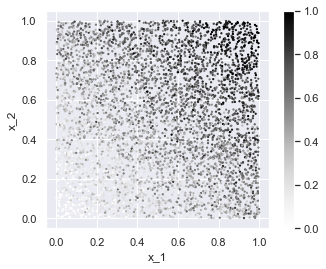

In [5]:
plt.figure(figsize=(5, 4))
plt.scatter(X_final[:5000,0], X_final[:5000,1], c=risk[:5000], s=1.5, cmap='Greys')
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.colorbar()
plt.show()

In [28]:
with open('checkpoints/synthetic_data.pickle', 'wb') as f:
    pickle.dump(data_f, f)

with open('checkpoints/synthetic_data_risk.pickle', 'wb') as f:
    pickle.dump(risk, f)
    
with open('checkpoints/synthetic_data_X_final.pickle', 'wb') as f:
    pickle.dump(X_final, f)
    
with open('checkpoints/synthetic_data_X_final.pickle', 'wb') as f:
    pickle.dump(X_final, f)   
    
with open('checkpoints/synthetic_data_Y_final.pickle', 'wb') as f:
    pickle.dump(Y_final, f)    
    
with open('checkpoints/synthetic_data_S_final.pickle', 'wb') as f:
    pickle.dump(S_final, f)

In [2]:
with open('checkpoints/synthetic_data.pickle', 'rb') as f:
    data_f = pickle.load(f)

with open('checkpoints/synthetic_data_risk.pickle', 'rb') as f:
    risk = pickle.load(f)
    
with open('checkpoints/synthetic_data_X_final.pickle', 'rb') as f:
    X_final = pickle.load(f)
    
with open('checkpoints/synthetic_data_X_final.pickle', 'rb') as f:
    X_final = pickle.load(f)   
    
with open('checkpoints/synthetic_data_Y_final.pickle', 'rb') as f:
    Y_final = pickle.load(f)    
    
with open('checkpoints/synthetic_data_S_final.pickle', 'rb') as f:
    S_final = pickle.load(f)

In [109]:
#Split the dataset into train and test
def splitTrainTest(X_final, S_final, Y_final, risk):
    dataset = np.concatenate((X_final, S_final.reshape(-1,1), risk.reshape(-1,1)), axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(dataset, Y_final, test_size = 0.3, stratify= Y_final, random_state = 1)

    S_train = X_train[:,2]
    S_test = X_test[:,2]
    risk_train = X_train[:,-1]
    risk_test = X_test[:,-1]
    X_train = X_train[:,:2]
    X_test = X_test[:,:2]
    
    return X_train, S_train, y_train, risk_train, X_test, S_test, y_test, risk_test


In [140]:
X_train, S_train, y_train, risk_train, X_test, S_test, y_test, risk_test = splitTrainTest(X_final=X_final,
                                                                                         S_final=S_final,
                                                                                         Y_final=Y_final,
                                                                                         risk = risk)

In [141]:
ds_train = {'X': X_train,
           'S':S_train, 
           'y':y_train,
           'risk':risk_train}

ds_test = {'X': X_test, 
           'S':S_test, 
           'y':y_test,
           'risk':risk_test}

In [142]:
with open('checkpoints/synthetic_data_train.pickle', 'wb') as f:
    pickle.dump(ds_train, f)
    
with open('checkpoints/synthetic_data_test.pickle', 'wb') as f:
    pickle.dump(ds_test, f)

In [8]:
with open('checkpoints/synthetic_data_test.pickle', 'rb') as f:
    ds_test = pickle.load(f)

X_test = ds_test['X']
S_test = ds_test['S']
y_test = ds_test['y']
risk_test = ds_test['risk']

with open('checkpoints/synthetic_data_train.pickle', 'rb') as f:
    ds_train = pickle.load(f)

X_train = ds_train['X']
S_train = ds_train['S']
y_train = ds_train['y']
risk_train = ds_train['risk']


# Foresee Algorithm

In [7]:
fsee= FORESEE(min_samples_leaf=[2])

fsee.fit(X=X_train,
         A=S_train,
         priv_class=1,
         y=y_train,
         k=200,
         scoring=['accuracy'])


Complete                    

In [10]:
estimated_risk_train, disc_acc_train, count_disc_train = fsee.risk_disc(X=X_train,
                                                               y=y_train,
                                                               A=S_train,
                                                               priv_class=1, 
                                                               alpha=0.0, 
                                                               beta=0.0)


In [11]:
estimated_risk_test, disc_acc_test, count_disc_test = fsee.risk_disc(X=X_test,
                                                            y=y_test,
                                                            A=S_test,
                                                            priv_class=1, 
                                                            alpha=0.0, 
                                                            beta=0.0)


In [19]:
with open('checkpoints/fsee.pickle', 'wb') as f:
    pickle.dump(fsee, f, protocol = pickle.HIGHEST_PROTOCOL)

with open('checkpoints/estimated_risk_train.pickle', 'wb') as f:
    pickle.dump(estimated_risk_train, f, protocol = pickle.HIGHEST_PROTOCOL)
    
with open('checkpoints/estimated_risk_test.pickle', 'wb') as f:
    pickle.dump(estimated_risk_test, f, protocol = pickle.HIGHEST_PROTOCOL)

In [6]:
with open('checkpoints/fsee.pickle', 'rb') as f:
    fsee= pickle.load(f)

with open('checkpoints/estimated_risk_train.pickle', 'rb') as f:
    estimated_risk_train = pickle.load(f)
    
with open('checkpoints/estimated_risk_test.pickle', 'rb') as f:
    estimated_risk_test = pickle.load(f)

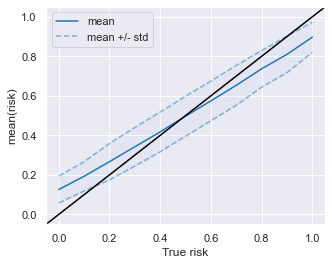

In [9]:
mean = []
std = []

sns.set()

for r in np.unique(risk_test):
    risks = estimated_risk_test['th_both'][np.where(risk_test==r)]
    mean.append(risks.mean())
    std.append(risks.std())

mean = np.array(mean)
std = np.array(std)
risks = np.unique(risk_test)

plt.figure(figsize=(5, 4))
plt.plot(risks, mean, c='tab:blue', label = 'mean')
plt.plot(risks, mean+std, linestyle='dashed', alpha=0.5, c='tab:blue', label = 'mean +/- std')
plt.plot(risks, mean-std, linestyle='dashed', alpha=0.5, c='tab:blue')
plt.fill_between(risks, mean+std, mean-std, alpha=0.03, color='tab:blue')

plt.xlabel('True risk')
plt.ylabel('mean(risk)')
plt.ylim([-0.05,1.05])
plt.xlim([-0.05,1.05])
plt.legend()
plt.axline((0,0), (1,1), color='black')

plt.show()

# S-BART

In [5]:
from causalml.inference.meta import BaseSLearner, BaseSClassifier, BaseTLearner, LRSRegressor
from bartpy.sklearnmodel import SklearnModel

bart_model = SklearnModel() 
s_learner = BaseSLearner(learner = bart_model)

In [6]:
#Training s-models
s_learners = {}

X_train_treated = np.append(X_train, S_train.reshape(-1,1), axis=1)

bart_model = SklearnModel() 

bart_model.fit(X_train_treated, y=y_train)


  0%|          | 0/200 [00:00<?, ?it/s]

Starting burn
Starting burn


  0%|          | 0/200 [00:00<?, ?it/s]

Starting burn
Starting burn


  0%|          | 0/200 [00:00<?, ?it/s]

Starting sampling


 98%|█████████▊| 197/200 [03:29<00:02,  1.02it/s]

Starting sampling


  2%|▏         | 4/200 [00:03<03:03,  1.07it/s]

Starting sampling


  0%|          | 0/200 [00:00<?, ?it/s]

Starting sampling


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]

SklearnModel()

In [7]:
with open('checkpoints/bart_model.pickle', 'wb') as f:
    pickle.dump(bart_model, f, protocol = pickle.HIGHEST_PROTOCOL)
    

In [10]:
with open('checkpoints/bart_model.pickle', 'rb') as f:
    bart_model = pickle.load(f)

In [11]:
#Predict ATE
X_test_treated = np.append(X_test, S_test.reshape(-1,1), axis=1)
risk_treated = bart_model.predict(X_test_treated)
X_test_changed = np.append(X_test, 1-S_test.reshape(-1,1), axis=1)
risk_not_treated = bart_model.predict(X_test_changed)
risk_BART = abs(risk_treated-risk_not_treated)

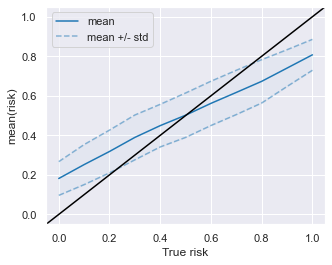

In [13]:
mean = []
std = []

sns.set()

for r in np.unique(risk_test):
    risks = risk_BART[np.where(risk_test==r)]
    mean.append(risks.mean())
    std.append(risks.std())

mean = np.array(mean)
std = np.array(std)
risks = np.unique(risk_test)

plt.figure(figsize=(5, 4))
plt.plot(risks, mean, c='tab:blue', label = 'mean')
plt.plot(risks, mean+std, linestyle='dashed', alpha=0.5, c='tab:blue', label = 'mean +/- std')
plt.plot(risks, mean-std, linestyle='dashed', alpha=0.5, c='tab:blue')
plt.fill_between(risks, mean+std, mean-std, alpha=0.03, color='tab:blue')

plt.xlabel('True risk')
plt.ylabel('mean(risk)')
plt.ylim([-0.05,1.05])
plt.xlim([-0.05,1.05])
plt.legend()
plt.axline((0,0), (1,1), color='black')

plt.show()